In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import sys
import os
import torch
from torch import nn
from collections import namedtuple, deque, OrderedDict
from copy import copy, deepcopy
import pandas as pd


from gymenv_2weekly_vax import *
from util_functions import *
from dqn_network import *
%load_ext autoreload
%autoreload 2

# Setup constant parameters. Setup PrRL

In [2]:
##### PARAMETERS ##### 
N = 50000
E_init = 10
threshold_highdanger = N * 100/100000
total_preRL_days = 60
np.set_printoptions(suppress=True)

# Simulate preRL
rl_initial_state, preRL_states = simulate_preRL(N, E_init, threshold_highdanger, total_preRL_days)

print("State after pre-RL simulation: {}".format(rl_initial_state))

State after pre-RL simulation: [48677.    69.    80.  1139.    35.    18.    18.    17.    16.    16.
    15.    14.]


# Start Grid Search (for gamma, alpha_linear)

In [3]:
##### HYPER RPARAMETERS ####
gamma_array = np.array([0.75, 0.8, 0.85, 0.9, 0.99])
alpha_linear_array = np.array([1])
# vaccine_tartdate starts counting from rl's first day
num_actions = 3
vaccine_startdate = 180


################################################
### Results for gamma=0.75, alpha_linear=1 ###
################################################


C:\Users\Terri\Desktop\UCLA\SPRING-2021\238\Project\dqn_network.py:190: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  qvals_next[dones_t] = 0 # Zero-out terminal states


Episode 1000 Mean Rewards 332.20		
Episode limit reached.


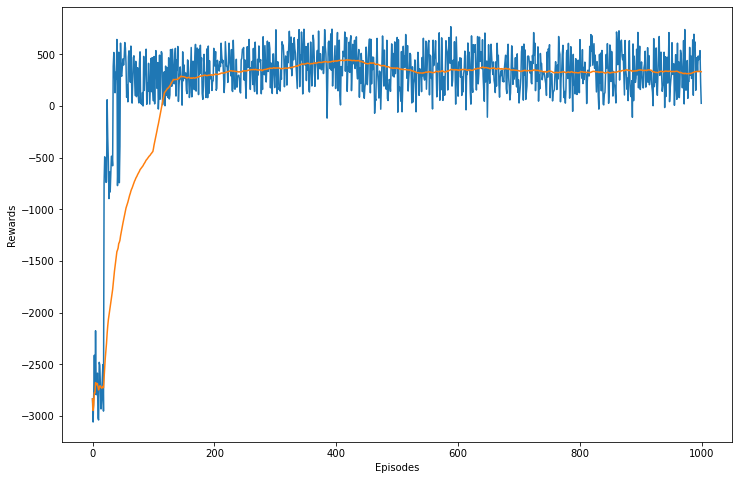

Peak mean reward: 447.46
Training Time: 00:02:31

Total Reward: 197.56
Length of RL actions: 366
Length of RL observations: 366
Shape of total observations: (426, 12)
Shape of total actions: (426,)
Shape of total new cases: (426,)
[ Metric Score for [gamma=0.75, alpha_linear=1]: 197.55999999999997 ]


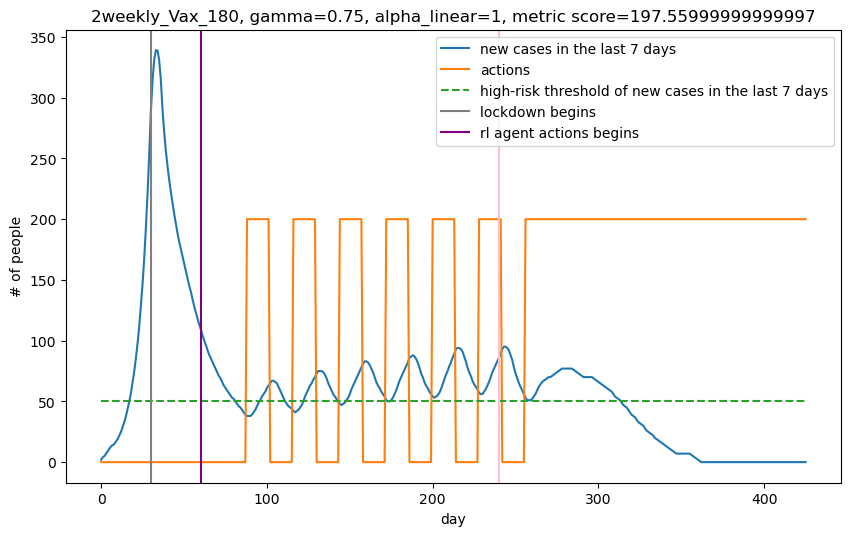

################################################
### Results for gamma=0.8, alpha_linear=1 ###
################################################


C:\Users\Terri\Desktop\UCLA\SPRING-2021\238\Project\dqn_network.py:190: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  qvals_next[dones_t] = 0 # Zero-out terminal states


Episode 1000 Mean Rewards 410.41		
Episode limit reached.


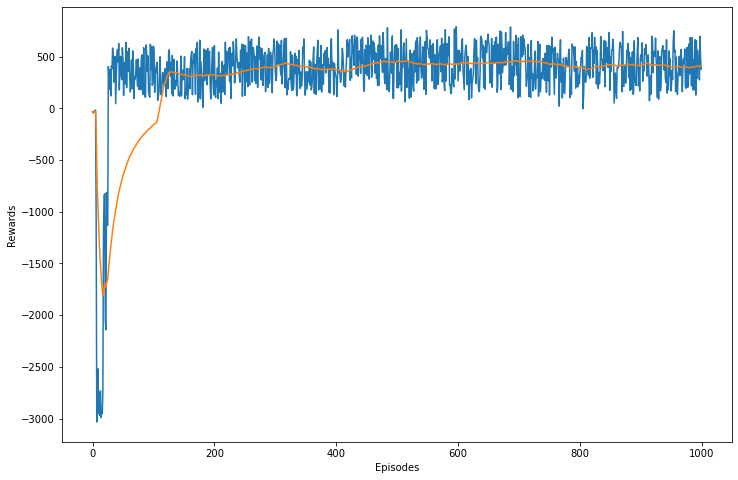

Peak mean reward: 461.07
Training Time: 00:02:28

Total Reward: 317.15999999999997
Length of RL actions: 366
Length of RL observations: 366
Shape of total observations: (426, 12)
Shape of total actions: (426,)
Shape of total new cases: (426,)
[ Metric Score for [gamma=0.8, alpha_linear=1]: 317.15999999999997 ]


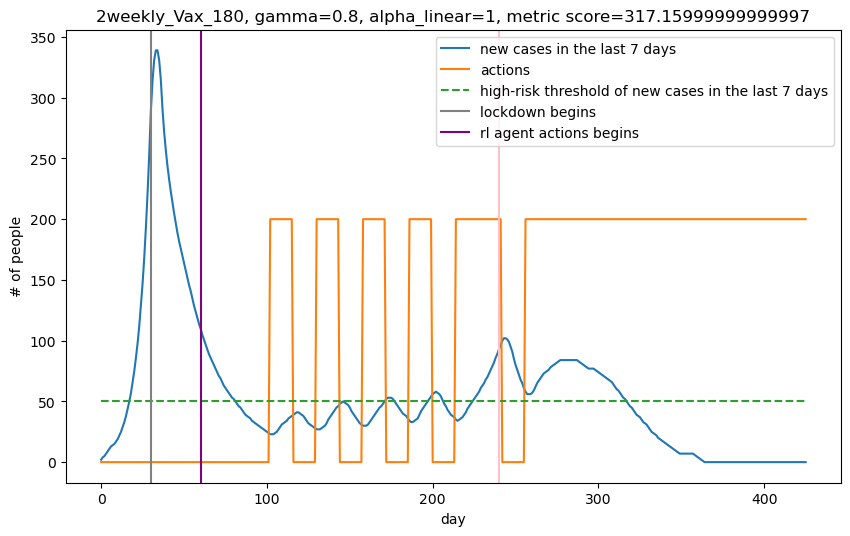

################################################
### Results for gamma=0.85, alpha_linear=1 ###
################################################


C:\Users\Terri\Desktop\UCLA\SPRING-2021\238\Project\dqn_network.py:190: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  qvals_next[dones_t] = 0 # Zero-out terminal states


Episode 1000 Mean Rewards 466.56		
Episode limit reached.


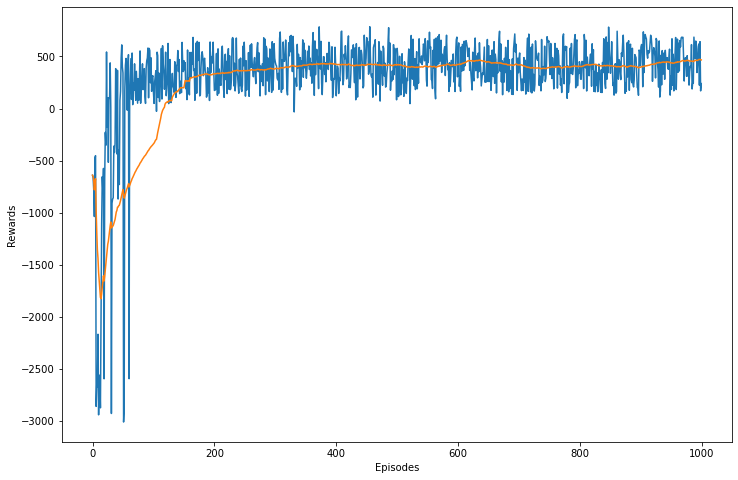

Peak mean reward: 472.06
Training Time: 00:02:27

Total Reward: 349.38
Length of RL actions: 366
Length of RL observations: 366
Shape of total observations: (426, 12)
Shape of total actions: (426,)
Shape of total new cases: (426,)
[ Metric Score for [gamma=0.85, alpha_linear=1]: 349.38000000000005 ]


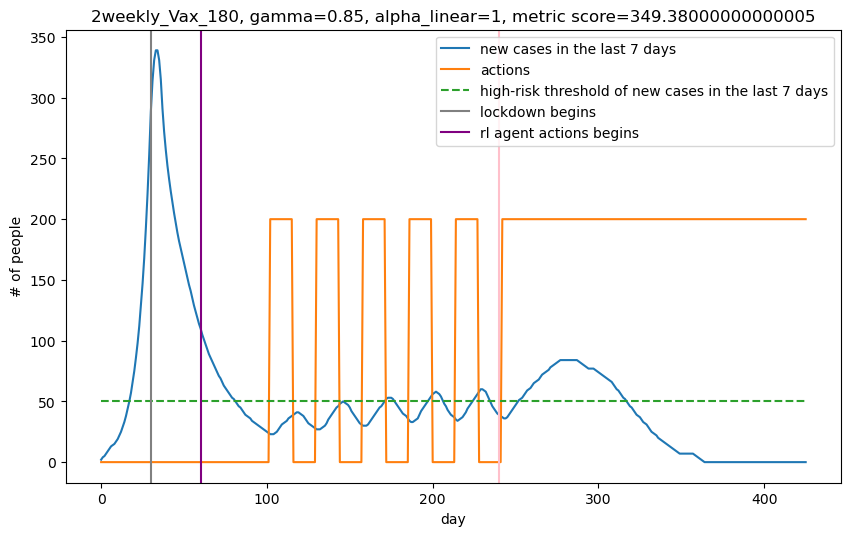

################################################
### Results for gamma=0.9, alpha_linear=1 ###
################################################


C:\Users\Terri\Desktop\UCLA\SPRING-2021\238\Project\dqn_network.py:190: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  qvals_next[dones_t] = 0 # Zero-out terminal states


Episode 1000 Mean Rewards 430.66		
Episode limit reached.


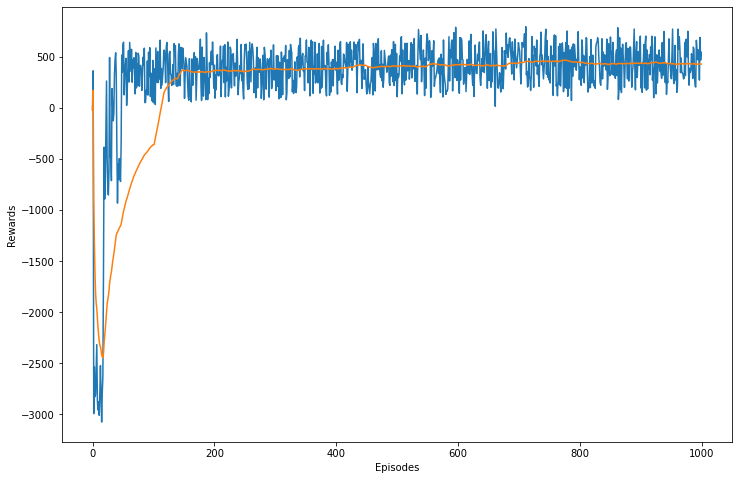

Peak mean reward: 469.53
Training Time: 00:02:25

Total Reward: 422.78
Length of RL actions: 366
Length of RL observations: 366
Shape of total observations: (426, 12)
Shape of total actions: (426,)
Shape of total new cases: (426,)
[ Metric Score for [gamma=0.9, alpha_linear=1]: 422.78000000000003 ]


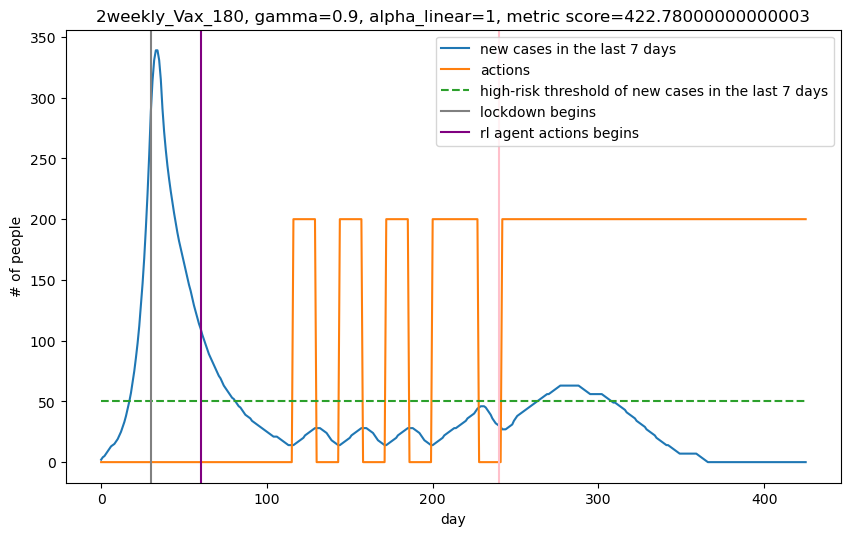

################################################
### Results for gamma=0.99, alpha_linear=1 ###
################################################


C:\Users\Terri\Desktop\UCLA\SPRING-2021\238\Project\dqn_network.py:190: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  qvals_next[dones_t] = 0 # Zero-out terminal states


Episode 1000 Mean Rewards 469.07		
Episode limit reached.


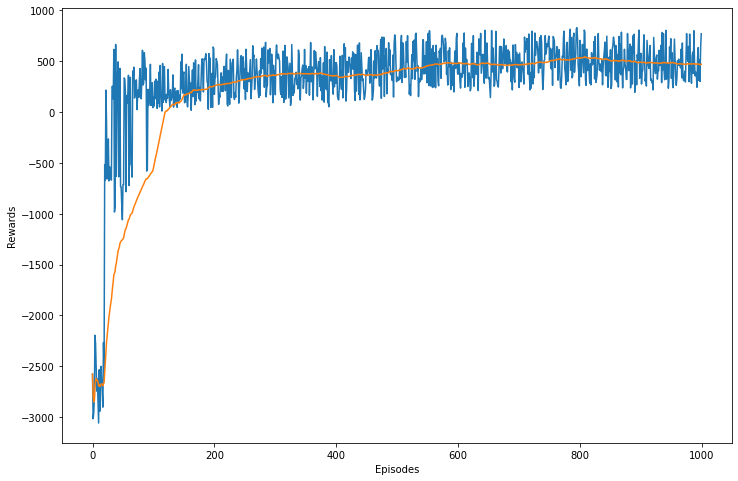

Peak mean reward: 543.91
Training Time: 00:02:25

Total Reward: 415.74
Length of RL actions: 366
Length of RL observations: 366
Shape of total observations: (426, 12)
Shape of total actions: (426,)
Shape of total new cases: (426,)
[ Metric Score for [gamma=0.99, alpha_linear=1]: 415.74 ]


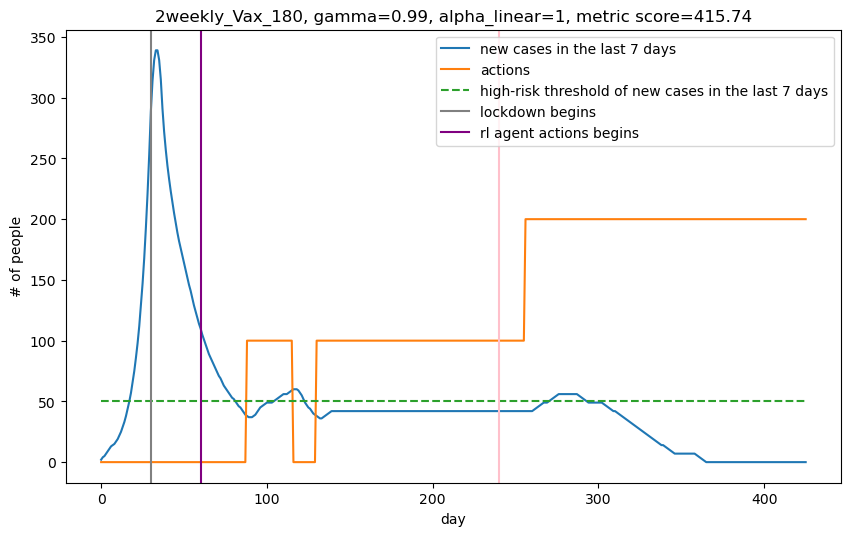

In [4]:
for i, gamma in enumerate(gamma_array):
    for j, alpha_linear in enumerate(alpha_linear_array):
        print('################################################')
        print('### Results for gamma={}, alpha_linear={} ###'.format(gamma, alpha_linear))
        print('################################################')
        
        ###################################
        ###### Initialize everything ######
        ###################################
        
        # initialize enviornment
        import time
        import shutil
        env = myEnv_2weekly_vax(N=50000, initial_state=rl_initial_state, 
                          alpha1=1, alpha2=2, alpha_linear=alpha_linear, 
                                vaccine_startdate=vaccine_startdate)

        # initialize dqn network & buffter
        dqn = QNetwork(env, learning_rate=1e-3)
        buffer = experienceReplayBuffer(memory_size=50000, burn_in=10000)

        # initialize dqn agent
        agent = DQNAgent(env, dqn, buffer)

        # train
        start_time = time.time()
        agent.train(gamma=gamma,
                    max_episodes=1000, 
                    network_update_frequency=1, 
                    network_sync_frequency=100)
        end_time = time.time()

        # plot reward
        agent.plot_rewards()


        x = end_time - start_time
        hours, remainder = divmod(x, 3600)
        minutes, seconds = divmod(remainder, 60)
        print("Peak mean reward: {:.2f}".format(
            max(agent.mean_training_rewards)))
        print("Training Time: {:02}:{:02}:{:02}\n".format(
            int(hours), int(minutes), int(seconds)))

        
        ###################################
        ######## Performance Test #########
        ###################################
        
        actions, observations = test_2week(env, agent) 
        print('Length of RL actions: {}'.format(len(actions)))
        print('Length of RL observations: {}'.format(len(observations)))
        
        ###################################
        ######### Graph + Metric ##########
        ###################################
        
        ### Combine preRL-data with RL-data, for graphical purposes
        # combine of observations
        total_observations = combine_preRL_and_RL(preRL_states, observations)
        print('Shape of total observations: {}'.format(total_observations.shape))

        # combine of actions
        # note the preRL days dont contain actions, so we're just concatenating 0's
        total_actions = combine_preRL_and_RL(np.zeros(total_preRL_days), actions)
        print('Shape of total actions: {}'.format(total_actions.shape))

        # get new-cases data from observations
        newcases_7days = np.sum(total_observations[:, 5:12], axis=1)
        print('Shape of total new cases: {}'.format(newcases_7days.shape))

        ### Metrics calculation
        # extract data for metric calc
        rl_actions = total_actions[60:]
        rl_newcases = total_observations[60:,5:]
        rl_newcases_7daysum = np.sum(rl_newcases, axis=1)

        # metric
        points_part1 = rl_actions
        points_part2 = ((rl_newcases_7daysum >= threshold_highdanger) * rl_newcases_7daysum)/ threshold_highdanger
        score = np.sum(points_part1 - points_part2)
        print('[ Metric Score for [gamma={}, alpha_linear={}]: {} ]'.format(gamma, alpha_linear,score))

        ### Make plot
        make_final_plot(total_preRL_days, total_actions, total_observations, 
                  newcases_7days, threshold_highdanger)
        plt.axvline(x=total_preRL_days+vaccine_startdate, color='pink', label="vaccine start date")

        plt.title('2weekly_Vax_{}, gamma={}, alpha_linear={}, metric score={}'.
                  format(vaccine_startdate, gamma, alpha_linear, score))

        plt.savefig('gamma{}_alpha{}.jpg'.format(gamma, alpha_linear))
        plt.show()